[*] Using device: cpu

==== Generating Normal Noise Data ====
[*] True beta: [8.822693  9.15004   3.8286376 9.593057  3.9044821]

--- Normal Iteration 1/5 ---


Hyperparam Updates: 100%|██████████| 4/4 [01:27<00:00, 21.97s/it, val_loss=0.680538 (MAE)]


> Temp beta: [8.790101  9.123983  3.7932246 9.676747  3.874207 ]
> True beta: [8.822693  9.15004   3.8286376 9.593057  3.9044821]
> Beta Difference: [ 0.03259182  0.02605629  0.03541303 -0.08369064  0.03027511]

--- Normal Iteration 2/5 ---


Hyperparam Updates: 100%|██████████| 4/4 [01:19<00:00, 19.86s/it, val_loss=0.943771 (MAE)]


> Temp beta: [8.760652  9.202118  3.7861557 9.655118  3.8352382]
> True beta: [8.822693  9.15004   3.8286376 9.593057  3.9044821]
> Beta Difference: [ 0.06204128 -0.05207825  0.0424819  -0.06206131  0.06924391]

--- Normal Iteration 3/5 ---


Hyperparam Updates: 100%|██████████| 4/4 [01:18<00:00, 19.66s/it, val_loss=0.715394 (MAE)]


> Temp beta: [8.858847 9.0887   3.786056 9.583772 3.870345]
> True beta: [8.822693  9.15004   3.8286376 9.593057  3.9044821]
> Beta Difference: [-0.03615379  0.06133938  0.04258156  0.00928497  0.03413701]

--- Normal Iteration 4/5 ---


Hyperparam Updates: 100%|██████████| 4/4 [01:18<00:00, 19.65s/it, val_loss=0.862590 (MAE)]


> Temp beta: [8.842539 9.142852 3.851821 9.605168 3.936077]
> True beta: [8.822693  9.15004   3.8286376 9.593057  3.9044821]
> Beta Difference: [-0.01984596  0.00718784 -0.02318335 -0.01211166 -0.03159499]

--- Normal Iteration 5/5 ---


Hyperparam Updates: 100%|██████████| 4/4 [01:12<00:00, 18.17s/it, val_loss=0.691461 (MAE)]


> Temp beta: [8.792615  9.152569  3.829113  9.577012  3.8081036]
> True beta: [8.822693  9.15004   3.8286376 9.593057  3.9044821]
> Beta Difference: [ 0.03007793 -0.00252914 -0.00047541  0.01604462  0.09637856]
[*] Final beta_opt: [8.792615  9.152569  3.829113  9.577012  3.8081036]
[*] Final U: []
[*] Final V: []
[*] Final S: [ 1.2455453  1.2522241  1.5530697 -1.7168956 -1.2068164]
[*] Final T: [-0.9218297  -0.34203961 -0.5549838   0.0799184   1.0027757 ]
[*] Train Autoloss (normal) MSE(y): 0.959968, MAE(y): 0.789251
[*] Train Autoloss (normal) MSE(beta): 0.002092, MAE(beta): 0.029101
[*] Val Autoloss (normal) MSE(y): 0.786645, MAE(y): 0.691458
[*] Val Autoloss (normal) MSE(beta): 0.002092, MAE(beta): 0.029101


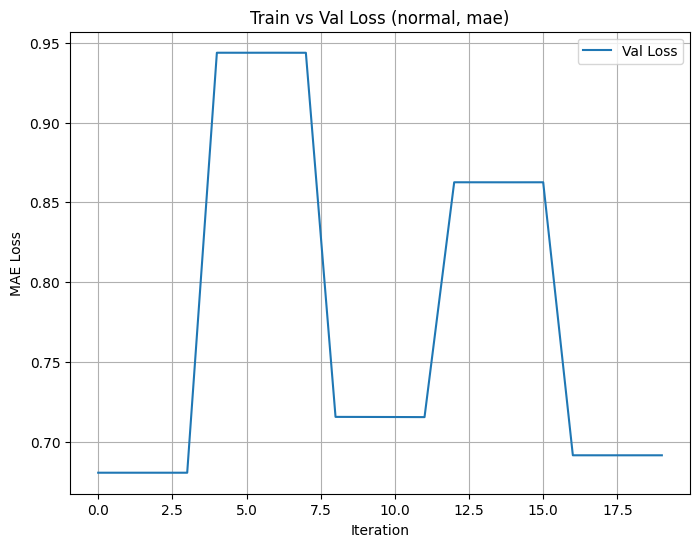

[*] Result and data saved to 'autoloss_result.pkl'.


In [9]:
# ####### VERSION 2.0.0 ########
# 1. check了qp构造函数

# ####### VERSION 1.2.1 ########
# 1. 完整增加了 Test 部分 和 Theoretical Loss 的绘制
# 2. 实现了保存结果到文件的功能并且优化了保存的参数
# 3. 增加了一个新的全局参数 VISUALIZE 用于控制是否绘制图像(以便在服务器上运行)

######## VERSION 1.2.0 ########
# 1. 使用 tqdm 为外层迭代及每轮训练添加进度条。
# 2. 记录并保存每次训练迭代的 train_loss 和 val_loss，在训练结束后进行可视化（用 Matplotlib 画图）。
# 3. 在训练完成后，保存最终学到的超参数 (U, V, S, T) 以及由它们解出的 beta_opt 到字典中，方便后续使用或持久化。
# 4. 可以自主选择 MAE / MSE 作为外层训练的损失函数，通过 loss_type 参数指定。
# 5. 优化了代码结构，将核心代码封装为函数，方便调用和复用。
# 6. 优化了部分变量名和注释，提高代码可读性。

######## TODO ########
# --- 重要 ---
# [1] ! tau 这个参数似乎处理的有问题. 这个是给定的还是要学习的?
# [2] ! 用大规模数据集测试 MAE+Gaussian & MSE+Laplace 的效果
# [3] ! 加一个最小一乘求beta的对照

# --- 一般 ---
# [4] 代码注释和文档整理. [!! 由于改变/增加了部分变量或名称, 需要更新docstring !!]
# [6] 中间优化的部分能不能从手动的GD改为利用Pytorch的优化器进行优化
# x[7] 最开始的两个QP构造函数的准确性验证 
# [8]优化中有时qpth会warning非稳定解, 需要关注其稳定性和影响



import random
import torch
from qpth.qp import QPFunction
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange
import pickle

################################################
#            1)   内层 QP 构造与求解
################################################

def build_qp_matrices(U, V, S, T, tau, X_train, y_train, lambda_reg):
    """
    构建Q, p, G, h，用于内层QP：
      minimize 0.5 * [beta^T * diag(lambda_reg) * beta + theta^T theta + sigma^T sigma]
               + tau^T sigma
      subject to  pi_li >= U_l(...) + V_l, ...
    """
    n, d = X_train.shape
    L = U.shape[0]
    H = S.shape[0]
    
    total_vars = d + L*n + 2*H*n  # [beta, pi, theta, sigma]
    
    # 对角线 Q
    Q_diag = torch.zeros(total_vars, dtype=X_train.dtype, device=X_train.device)
    Q_diag[:d] = lambda_reg              # beta 的正则
    Q_diag[d + L*n : d + L*n + H*n] = 1.0  # theta
    #Q_diag[d + L*n + H*n : ] = 1.0         # sigma
    
    Q = torch.diag(Q_diag).unsqueeze(0)
    
    # p 向量
    p = torch.zeros(total_vars, dtype=X_train.dtype, device=X_train.device)
    p[d : d + L*n] = 1.0
    p[d + L*n + H*n:] = tau.repeat(n)  # sigma部分
    p = p.unsqueeze(0)
    
    # 不等式约束 G z <= h
    G_rows = 2*L*n + 2*H*n + d
    G = torch.zeros(G_rows, total_vars, dtype=X_train.dtype, device=X_train.device)
    h_val = torch.zeros(G_rows, dtype=X_train.dtype, device=X_train.device)
    
    row_idx = 0
    
    # pi_li >= U_l * (y_i - x_i^T beta) + V_l 转为 -pi_li - u_li x_i^T beta <= -u_li y_i - v_li
    for i in range(n):
        for l in range(L):
            G[row_idx, :d] = -U[l] * X_train[i]
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = -U[l]*y_train[i] - V[l]
            row_idx += 1
    
    # pi_li >= 0
    for i in range(n):
        for l in range(L):
            G[row_idx, d + l*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # theta_hi + sigma_hi >= S_h*(y_i - x_i^T beta) + T_h 转为 -theta_hi - sigma_hi - s_hi x_i^T beta <= -s_hi y_i - t_hi
    for i in range(n):
        for h_ in range(H):
            G[row_idx, :d] = -S[h_] * X_train[i]
            G[row_idx, d + L*n + h_*n + i] = -1.0
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = -S[h_]*y_train[i] - T[h_]
            row_idx += 1

    # sigma_hi >= 0
    for i in range(n):
        for h_ in range(H):
            G[row_idx, d + L*n + H*n + h_*n + i] = -1.0
            h_val[row_idx] = 0.0
            row_idx += 1

    # beta_j >= 0
    for j in range(d):
        G[row_idx, j] = -1.0
        h_val[row_idx] = 0.0
        row_idx += 1
    
    G = G.unsqueeze(0)
    h = h_val.unsqueeze(0)
    
    # 数值扰动，确保 Q SPD
    eps = 1e-4
    Q = Q + eps * torch.eye(total_vars, dtype=X_train.dtype, device=X_train.device).unsqueeze(0)
    
    return Q, p, G, h

def solve_inner_qpth(U, V, S, T, tau, X_train, y_train, lambda_reg):
    """
    Solve inner QP problem to obtain optimal beta coefficients.

    调用 qpth.QPFunction 求解给定超参数下的内层 QP 问题, 得到最优 beta 系数，调用的是抽样的xtrain和ytrain

    Constructs and solves a quadratic programming problem using qpth.QPFunction,
    minimizing a regularized objective subject to constraints defined by hyperparameters.

    Args:
        U (torch.Tensor): Linear constraint coefficients, shape (L,).
        V (torch.Tensor): Linear constraint biases, shape (L,).
        S (torch.Tensor): Additional constraint coefficients, shape (H,).
        T (torch.Tensor): Additional constraint biases, shape (H,).
        tau (torch.Tensor): Slack variable penalties, shape (H,).
        X_train (torch.Tensor): Training features, shape (n_samples, n_features).
        y_train (torch.Tensor): Training targets, shape (n_samples,).
        lambda_reg (float): Regularization strength for beta.

    Returns:
        torch.Tensor: Optimal beta coefficients, shape (n_features,).

    Notes:
        - Objective: 0.5 * (beta^T * diag(lambda_reg) * beta + theta^T * theta + sigma^T * sigma) + tau^T * sigma.
        - Constraints are derived from U, V, S, T.
        - Assumes all tensors are on the same device.
    """
    Q, p, G, h = build_qp_matrices(U, V, S, T, tau, X_train, y_train, lambda_reg)
    z = QPFunction(verbose=False)(Q, p, G, h, torch.empty(0, device=X_train.device), torch.empty(0, device=X_train.device))
    d = X_train.shape[1]
    beta_opt = z[:, :d].squeeze(0)
    return beta_opt

################################################
#   2) 外层训练 (带Train/Val) + 梯度计算
################################################
    

def compute_outer_gradients(
    X_train, y_train,
    X_val,   y_val,
    U, V, S, T, tau,
    lambda_reg,
    loss_type="mse"
):
    """
    Compute outer loss gradients w.r.t. hyperparameters U, V, S, T.

    Solves the inner QP for beta, computes the chosen validation loss (MSE or MAE),
    and calculates gradients of the outer loss via backpropagation.

    Args:
        X_train (torch.Tensor): Training features, shape (n_train_samples, n_features).
        y_train (torch.Tensor): Training targets, shape (n_train_samples,).
        X_val (torch.Tensor): Validation features, shape (n_val_samples, n_features).
        y_val (torch.Tensor): Validation targets, shape (n_val_samples,).
        U (torch.Tensor): Linear constraint coefficients, shape (L,), requires grad.
        V (torch.Tensor): Linear constraint biases, shape (L,), requires grad.
        S (torch.Tensor): Additional constraint coefficients, shape (H,), requires grad.
        T (torch.Tensor): Additional constraint biases, shape (H,), requires grad.
        tau (torch.Tensor): Slack variable penalties, shape (H,).
        lambda_reg (float): Regularization strength for inner QP beta.
        loss_type (str): Type of loss function on validation set. Either "mse" or "mae".

    Returns:
        dict: A dictionary with the following keys:
            - "beta_opt": Optimal beta, shape (n_features,).
            - "loss_outer": Validation loss (i.e. OUTER LOSS) (float, MSE or MAE).
            - "U_grad", "V_grad", "S_grad", "T_grad": Gradients w.r.t. U, V, S, T.

    Notes:
        - Outer loss is chosen based on 'loss_type':
            * "mse": (1/n_val) * sum((y_val - X_val @ beta_opt)^2)
            * "mae": (1/n_val) * sum(|y_val - X_val @ beta_opt|)
        - If an unknown loss_type is provided, raises ValueError.
        - Uses PyTorch autograd; any None gradients replaced with zeros.
        - Assumes all tensors on same device.
    """
    # 1) Solve inner QP
    beta_opt = solve_inner_qpth(U, V, S, T, tau, X_train, y_train, lambda_reg)

    # 2) Compute outer loss on validation set
    n_val = X_val.shape[0]
    y_val_pred = X_val @ beta_opt

    if loss_type == "mse":
        # Mean Squared Error
        loss_outer = (1.0 / n_val) * (y_val - y_val_pred).pow(2).sum()
    elif loss_type == "mae":
        # Mean Absolute Error
        loss_outer = (1.0 / n_val) * (y_val - y_val_pred).abs().sum()
    else:
        raise ValueError(f"Unsupported loss_type '{loss_type}'. Choose 'mse' or 'mae'.")

    # 3) Backprop to get gradients w.r.t. U, V, S, T
    loss_outer.backward()

    U_grad = U.grad.clone() if U.grad is not None else torch.zeros_like(U)
    V_grad = V.grad.clone() if V.grad is not None else torch.zeros_like(V)
    S_grad = S.grad.clone() if S.grad is not None else torch.zeros_like(S)
    T_grad = T.grad.clone() if T.grad is not None else torch.zeros_like(T)
    
    # 4) Zero out grads to avoid accumulation
    if U.grad is not None:
        U.grad.zero_()
    if V.grad is not None:
        V.grad.zero_()
    if S.grad is not None:
        S.grad.zero_()
    if T.grad is not None:
        T.grad.zero_()
    
    return {
        "beta_opt": beta_opt.detach().clone(),
        "loss_outer": loss_outer.item(),
        "U_grad": U_grad,
        "V_grad": V_grad,
        "S_grad": S_grad,
        "T_grad": T_grad
    }

def train_hyperparams(X_train, y_train,
                      X_val,   y_val,
                      U, V, S, T, tau,
                      lambda_reg,
                      lr=1e-2,
                      num_hyperparam_iterations=50,
                      loss_type="mse"):
    """
    Train hyperparameters U, V, S, T via gradient descent on outer MSE loss.

    Performs multiple steps of gradient descent to optimize U, V, S, T based on the outer
    MSE loss, computed using beta from an inner QP solver.

    Args:
        X_train (torch.Tensor): Training features, shape (n_train_samples, n_features).
        y_train (torch.Tensor): Training targets, shape (n_train_samples,).
        X_val (torch.Tensor): Validation features, shape (n_val_samples, n_features).
        y_val (torch.Tensor): Validation targets, shape (n_val_samples,).
        U (torch.Tensor): Linear constraint coefficients, shape (L,), requires grad.
        V (torch.Tensor): Linear constraint biases, shape (L,), requires grad.
        S (torch.Tensor): Additional constraint coefficients, shape (H,), requires grad.
        T (torch.Tensor): Additional constraint biases, shape (H,), requires grad.
        tau (torch.Tensor): Slack variable penalties, shape (H,).
        lambda_reg (float): Regularization parameter for inner QP beta.
        lr (float, optional): Learning rate. Defaults to 1e-2.
        num_hyperparam_iterations (int, optional): Number of iterations for hyperparameter by GD. Defaults to 50.
        loss_type (str, optional): Type of loss function on validation set. Defaults to "mse".

    Returns:
        tuple: (U, V, S, T, loss_history)
            - U, V, S, T (torch.Tensor): Updated hyperparameters.
            - loss_history (list): MSE loss per step.
            - loss_history_val (list): MSE loss on validation set per step.

    Notes:
        - Uses compute_outer_gradients for gradient computation.
        - Prints MSE every 10 steps.
        - Assumes all tensors are on the same device.
    """
    loss_outer_history = []

    inner_range = trange(num_hyperparam_iterations, desc='Hyperparam Updates', leave=True)
    
    for step in inner_range:
        results = compute_outer_gradients(X_train, y_train,
                                          X_val,   y_val,
                                          U, V, S, T, tau,
                                          lambda_reg,
                                          loss_type)

        loss_val = results["loss_outer"]
        U_grad, V_grad = results["U_grad"], results["V_grad"]
        S_grad, T_grad = results["S_grad"], results["T_grad"]
        
        with torch.no_grad():
            U -= lr * U_grad
            V -= lr * V_grad
            S -= lr * S_grad
            T -= lr * T_grad
        
        # 继续需要梯度
        U.requires_grad_(True)
        V.requires_grad_(True)
        S.requires_grad_(True)
        T.requires_grad_(True)
        
        loss_outer_history.append(loss_val)
        captial_loss_type = loss_type.upper()
        inner_range.set_postfix(val_loss = f" {loss_val:.6f} ({captial_loss_type})")
        # if (step+1) % 10 == 0:
        #     print(f"[outer step {step+1}/{outer_steps}] Val MSE loss = {loss_val:.6f}")
    
    return U, V, S, T, loss_outer_history

################################################
#    3) 辅助: 评估/打印
################################################

def evaluate_and_print(X, y, beta_est, beta_true, label=""):
    """
    Evaluate predictions using beta_est on (X, y) and print MSE/MAE metrics.

    Computes predictions with estimated beta coefficients, calculates MSE and MAE
    on the given data, and optionally compares beta_est to beta_true.

    Args:
        X (torch.Tensor): Feature matrix, shape (n_samples, n_features).
        y (torch.Tensor): Target vector, shape (n_samples,).
        beta_est (torch.Tensor): Estimated beta coefficients, shape (n_features,).
        beta_true (torch.Tensor): True beta coefficients, shape (n_features,), optional.
        label (str, optional): Prefix for printed metrics. Defaults to "".

    Notes:
        - Prints MSE and MAE for predictions, and Beta MSE/MAE if beta_true is provided.
        - Computations are performed without gradient tracking.
    """
    with torch.no_grad():
        y_pred = X @ beta_est
        mse = ((y_pred - y)**2).mean().item()
        mae = (y_pred - y).abs().mean().item()
        print(f"{label} MSE(y): {mse:.6f}, MAE(y): {mae:.6f}")
        if beta_true is not None:
            beta_mse = ((beta_est - beta_true)**2).mean().item()
            beta_mae = (beta_est - beta_true).abs().mean().item()
            print(f"{label} MSE(beta): {beta_mse:.6f}, MAE(beta): {beta_mae:.6f}")


################################################
#    4)  核心: 生成数据 & 运行实验
################################################

def generate_full_data(n, d, distribution='laplace', scale=1.0, seed=42, device="cpu"):
    """
    
    Generate synthetic data (X, y, beta_true) with noise from a specified distribution.

    Creates a dataset where features X are drawn from a standard normal distribution,
    true coefficients beta_true from a uniform distribution, and targets y are computed
    as a linear combination of X and beta_true plus noise from the specified distribution.

    Args:
        n (int): Number of samples.
        d (int): Number of features.
        distribution (str, optional): Type of noise distribution ('laplace', 'normal', etc.). Defaults to 'laplace'.
        scale (float, optional): Scale parameter for the noise distribution. Defaults to 1.0.
        seed (int, optional): Random seed for reproducibility. Defaults to 42.
        device (str or torch.device, optional): Device to generate tensors on. Defaults to "cpu".

    Returns:
        tuple: (X, y, beta_true)
            - X (torch.Tensor): Feature matrix, shape (n, d).
            - y (torch.Tensor): Target vector, shape (n,).
            - beta_true (torch.Tensor): True coefficients, shape (d,).

    Notes:
        - beta_true is sampled from Uniform(0, 10).
        - X is sampled from N(0, 1).
        - Noise (eps) is sampled from the specified distribution with given scale.
        - Supported distributions: 'laplace', 'normal'. Others raise ValueError.
        - All tensors are placed on the specified device.
    """
    torch.manual_seed(seed)
    from torch.distributions import Laplace, Normal
                                                  
    # Generate true beta
    beta_true = torch.rand(d, device=device) * 10
    X = torch.randn(n, d, device=device)
    
    # Generate noise based on specified distribution
    if distribution.lower() == 'laplace':
        dist = Laplace(0.0, scale)
    elif distribution.lower() == 'normal':
        dist = Normal(0.0, scale)   
    else:
        raise ValueError(f"Unsupported distribution: {distribution}. Supported options: 'laplace', 'normal'")
    
    eps = dist.sample((n,)).to(device)
    y = X @ beta_true + eps
    return X, y, beta_true

def sample_data(n_sample, X_full,y_full,seed=42, device="cpu"):
    """
    Sample data from the full dataset.

    Args:
        n_train (int): Number of training samples.
        X_full (torch.Tensor): Full feature matrix, shape (n_full_samples, n_features).
        y_full (torch.Tensor): Full target vector, shape (n_full_samples,).
        seed (int, optional): Random seed for reproducibility. Defaults to 42.
        device (str or torch.device, optional): Device to generate tensors on. Defaults to "cpu".

    Returns:
        tuple: (X_train, y_train)
            - X_train (torch.Tensor): Sampled training feature matrix, shape (n_train_samples, n_features).
            - y_train (torch.Tensor): Sampled training target vector, shape (n_train_samples,).
    """
    torch.manual_seed(seed)
    indices = torch.randperm(X_full.size(0))
    selected_indices = indices[:n_sample]
    remaining_indices = indices[n_sample:]
    
    X_sample = X_full[selected_indices].to(device)
    y_sample = y_full[selected_indices].to(device)
    X_remaining = X_full[remaining_indices].to(device)
    y_remaining = y_full[remaining_indices].to(device)
    
    return X_sample, y_sample, X_remaining, y_remaining
#sample train and val都用这个来做

def log_msg(message, verbose = True):
    if verbose:
        print(message)

def run_experiment(total_sample_size=200, feature_dimension=5,
                   L=2, H=2,
                   lambda_reg=0.1,
                   num_hyperparam_iterations=10,
                   lr=1e-2,
                   num_global_updates=20,
                   num_training_samples=150,
                   num_val_samples=50,
                   seed=42,
                   distribution='laplace',
                   scale=1.0,
                   device=None,
                   loss_type="mse",
                   verbose=True,
                   visualize=True):
    """
    Optimize hyperparameters for a regression experiment with specified noise distribution.

    Generates data, splits it into train/val sets, and runs multiple iterations of hyperparameter
    optimization using gradient descent. Evaluates performance on both sets each iteration.

    Args:
        total_sample_size (int, optional): Total samples. Defaults to 200.
        feature_dimension (int, optional): Features. Defaults to 5.
        L (int, optional): Size of U, V. Defaults to 2.
        H (int, optional): Size of S, T. Defaults to 2.
        lambda_reg (float, optional): Regularization for inner QP. Defaults to 0.1.
        outer_steps (int, optional): Steps per iteration. Defaults to 10.
        lr (float, optional): Learning rate. Defaults to 1e-2.
        num_global_updates (int, optional): Outer iterations. Defaults to 20.
        num_training_samples (int, optional): Training samples. Defaults to 150.
        seed (int, optional): Random seed. Defaults to 42.
        distribution (str, optional): Noise type ('laplace', 'normal'). Defaults to 'laplace'.
        scale (float, optional): Noise scale. Defaults to 1.0.
        device (str or torch.device, optional): Device (auto-detects CUDA if None). Defaults to None.
        loss_type (str, optional): Type of loss function ('mse' or 'mae'). Defaults to "mse".
        verbose (bool, optional): Whether to print progress. Defaults to True.

    Returns:
        tuple: (U, V, S, T, beta_opt)
            - U, V (torch.Tensor): Optimized constraints, shape (L,).
            - S, T (torch.Tensor): Optimized constraints, shape (H,).
            - beta_opt (torch.Tensor): Final coefficients, shape (d,).

    Notes:
        - Uses generate_data for data creation.
        - Optimizes U, V, S, T via train_hyperparams.
        - Prints train/val performance per iteration.
        - Assumes solve_inner_qpth and evaluate_and_print are defined.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    log_msg(f"[*] Using device: {device}", verbose)
    
    # 1) Generate data
    log_msg(f"\n==== Generating {distribution.capitalize()} Noise Data ====", verbose)
    X_full, y_full, beta_true = generate_full_data(total_sample_size, feature_dimension, distribution=distribution, scale=scale, seed=seed, device=device)
    log_msg(f"[*] True beta: {beta_true.detach().cpu().numpy()}", verbose)

    # 2) Train-Val Split
    #log_msg(f"[*] Splitting data into train/val sets ({num_training_samples}/{total_sample_size-num_training_samples})", verbose)
    #X_train, y_train = X[:num_training_samples], y[:num_training_samples]
    #X_val,   y_val   = X[num_training_samples:], y[num_training_samples:]
    #这里改用sample函数或者直接用shuffle来做，位置改到下面第一个for那里
    
    # 3) Initialize hyperparameters
    U = torch.randn(L, device=device, requires_grad=True)
    V = torch.randn(L, device=device, requires_grad=True)
    S = torch.randn(H, device=device, requires_grad=True)
    T = torch.randn(H, device=device, requires_grad=True)
    tau = torch.ones(H, device=device, requires_grad=False) *100 # Usually fixed
    
    
    # 4) Multi-round for-loop: Perform train_hyperparams in each round

    all_val_losses = []

    
    # outer_range = trange(num_global_updates, desc="Global Iterations (qpth + GD)") 

    for it in range(num_global_updates):
        log_msg(f"\n--- {distribution.capitalize()} Iteration {it+1}/{num_global_updates} ---", verbose)
        #sample放在这里
        seed = random.randint(0, 2**32 - 1)
        X_train, y_train, X_remaining, y_remaining = sample_data(num_training_samples, X_full, y_full, seed=seed, device=device)
        X_val, y_val, _, _ = sample_data(num_val_samples, X_remaining, y_remaining, seed=seed, device=device)
        U, V, S, T, val_loss_hist = train_hyperparams(
            X_train, y_train,
            X_val,   y_val,
            U, V, S, T, tau,
            lambda_reg = lambda_reg,
            lr = lr,
            num_hyperparam_iterations = num_hyperparam_iterations,
            loss_type = loss_type
        )
        # Solve for final beta_opt after each round
        #这个beta不需要计算，直接在前一个函数return一个beta出来就可以
        beta_opt = solve_inner_qpth(U, V, S, T, tau, X_train, y_train, lambda_reg)
        log_msg(f"> Temp beta: {beta_opt.detach().cpu().numpy()}", 
        verbose)
        log_msg(f"> True beta: {beta_true.detach().cpu().numpy()}", verbose)
        log_msg(f"> Beta Difference: {beta_true.detach().cpu().numpy()-beta_opt.detach().cpu().numpy()}", verbose)

        all_val_losses.append(val_loss_hist)


    
    params = {
        "U": U.detach().clone(),
        "V": V.detach().clone(),
        "S": S.detach().clone(),
        "T": T.detach().clone(),
        "beta_opt": beta_opt.detach().clone(),
        "num_H":H,
        "num_L":L,
        "lambda_reg":lambda_reg,
        "tau":tau,
        "data_distribution":distribution,
        "scale":scale,
        "metric":loss_type
    }

    data = {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "beta_true": beta_true
    }


    log_msg(f"[*] Final beta_opt: {beta_opt.detach().cpu().numpy()}", verbose)
    log_msg(f"[*] Final U: {U.detach().cpu().numpy()}", verbose)
    log_msg(f"[*] Final V: {V.detach().cpu().numpy()}", verbose)
    log_msg(f"[*] Final S: {S.detach().cpu().numpy()}", verbose)
    log_msg(f"[*] Final T: {T.detach().cpu().numpy()}", verbose)
    if verbose:
        evaluate_and_print(X_train, y_train, beta_opt, beta_true, label=f"[*] Train Autoloss ({distribution})")
        evaluate_and_print(X_val, y_val, beta_opt, beta_true, label=f"[*] Val Autoloss ({distribution})")   

    val_losses_flat   = [val for iteration_losses in all_val_losses   for val in iteration_losses]
    
    if visualize:
        plt.figure(figsize=(8,6))
        # plt.plot(train_losses_flat, label="Train Loss")
        plt.plot(val_losses_flat, label="Val Loss")
        plt.xlabel("Iteration")
        plt.ylabel(f"{loss_type.upper()} Loss")
        plt.title(f"Train vs Val Loss ({distribution}, {loss_type})")
        plt.grid(True)
        plt.legend()
        plt.show()

    return params, data, all_val_losses

################################################
#  运行实验
################################################

# 运行前请确认下列参数是否符合实验需求

TOTAL_SAMPLE_SIZE = 1000
FEATURE_DIMENSION = 5
L = 0
H = 5
LAMBDA_REG = 0.1
NUM_HYPERPARAM_ITERATIONS = 4
LR = 1e-2
NUM_GLOBAL_UPDATES = 5
NUM_TRAINING_SAMPLES = int(0.3*TOTAL_SAMPLE_SIZE)
NUM_VAL_SAMPLES = int(0.2*TOTAL_SAMPLE_SIZE)
SEED = 42
DISTRIBUTION = 'normal'
SCALE = 1.0
DEVICE = None
LOSS_TYPE = "mae"
VERBOSE = True
VISUALIZE = True

# 运行实验
autoloss_result, data, val_losses_list = run_experiment(total_sample_size=TOTAL_SAMPLE_SIZE,   
                    feature_dimension=FEATURE_DIMENSION,
                    L=L, H=H,
                    lambda_reg=LAMBDA_REG,
                    num_hyperparam_iterations=NUM_HYPERPARAM_ITERATIONS,
                    lr=LR,
                    num_global_updates=NUM_GLOBAL_UPDATES,
                    num_training_samples=NUM_TRAINING_SAMPLES,
                    seed=SEED,
                    distribution=DISTRIBUTION,
                    scale=SCALE,
                    device=DEVICE,
                    loss_type=LOSS_TYPE,
                    verbose=VERBOSE,
                    visualize=VISUALIZE)

# 保存实验结果
with open('autoloss_result.pkl', 'wb') as f:
    pickle.dump(autoloss_result, f)
    f.close
with open('autoloss_data.pkl', 'wb') as f:
    pickle.dump(data, f)
    f.close
print("[*] Result and data saved to 'autoloss_result.pkl'.")

In [10]:
################################################
#    5)  测试: 读取数据 & 测试
################################################

# OLS 训练
def train_ols(X_train, y_train):
    """
    Train OLS on the given training data.

    Args:
        X_train (torch.Tensor): Training features, shape (n_train_samples, n_features).
        y_train (torch.Tensor): Training targets, shape (n_train_samples,).

    Returns:
        torch.Tensor: Estimated beta coefficients, shape (n_features,).
    """
    beta_ols = torch.linalg.lstsq(X_train, y_train).solution
    return beta_ols

#加一个最小一乘的函数

#  生成测试数据
def generate_test_data(num_test_sample, feature_dimension, beta_true, distribution='laplace', scale=1.0, seed=42, device="cpu"):
    """
    Generate synthetic test data (X, y) with noise from a specified distribution.

    Creates a dataset where features X are drawn from a standard normal distribution,
    and targets y are computed as a linear combination of X and beta_true plus noise
    from the specified distribution.

    Args:
        num_test_sample (int): Number of test samples.
        feature_dimension (int): Number of features.
        beta_true (torch.Tensor): True coefficients, shape (n_features,).
        distribution (str, optional): Type of noise distribution ('laplace', 'normal'). Defaults to 'laplace'.
        scale (float, optional): Scale parameter for the noise distribution. Defaults to 1.0.
        seed (int, optional): Random seed for reproducibility. Defaults to 42.
        device (str or torch.device, optional): Device to generate tensors on. Defaults to "cpu".

    Returns:
        tuple: (X, y)
            - X (torch.Tensor): Feature matrix, shape (n_samples, n_features).
            - y (torch.Tensor): Target vector, shape (n_samples,).

    Notes:
        - X is sampled from N(0, 1).
        - Noise (eps) is sampled from the specified distribution with given scale.
        - Supported distributions: 'laplace', 'normal'. Others raise ValueError.
        - All tensors are placed on the specified device.
    """
    torch.manual_seed(seed)
    from torch.distributions import Laplace, Normal
    
    X = torch.randn(num_test_sample, feature_dimension, device=device)
    
    if distribution.lower() == 'laplace':
        dist = Laplace(0.0, scale)
    elif distribution.lower() == 'normal':
        dist = Normal(0.0, scale)
    else:
        raise ValueError(f"Unsupported distribution: {distribution}. Supported options: 'laplace', 'normal'")
    
    eps = dist.sample((num_test_sample,)).to(device)
    y = X @ beta_true + eps
    return X, y

#  测试 

def compute_test_Xbeta(X_test, y_test, beta_est, beta_true):
    """
    Evaluate predictions using beta_est on (X_test, y_test) and print MSE/MAE metrics.

    Computes predictions with estimated beta coefficients by Y_pred = X @ beta_est,
    calculates MSE and MAE on the given data, and optionally compares beta_est to beta_true.

    Args:
        X_test (torch.Tensor): Feature matrix, shape (n_samples, n_features).
        y_test (torch.Tensor): Target vector, shape (n_samples,).
        beta_est (torch.Tensor): Estimated beta coefficients, shape (n_features,).
        beta_true (torch.Tensor): True beta coefficients, shape (n_features,).
        label (str, optional): Prefix for printed metrics. Defaults to "".
    
    Returns:
        tuple: (y_mse, y_mae, beta_mse, beta_mae)
            - y_mse (float): MSE for predictions on y_test.
            - y_mae (float): MAE for predictions on y_test.
            - beta_mse (float): MSE for beta_est compared to beta_true.
            - beta_mae (float): MAE for beta_est compared to beta_true.

    Notes:
        - Prints MSE and MAE for predictions, and Beta MSE/MAE if beta_true is provided.
        - Computations are performed without gradient tracking.
    """
    beta_est = beta_est.to(X_test.device)
    beta_true = beta_true.to(X_test.device)

    with torch.no_grad():
        y_pred = X_test @ beta_est
        y_mse = ((y_pred - y_test)**2).mean().item()
        y_mae = (y_pred - y_test).abs().mean().item()
        # print(f"{label} MSE(y): {mse:.6f}, MAE(y): {mae:.6f}")
        if beta_true is not None:
            beta_mse = ((beta_est - beta_true)**2).mean().item()
            beta_mae = (beta_est - beta_true).abs().mean().item()
            # print(f"{label} MSE(beta): {beta_mse:.6f}, MAE(beta): {beta_mae:.6f}")
    return y_mse, y_mae, beta_mse, beta_mae

# 读取训练/验证数据
train_val_data = pickle.load(open('autoloss_data.pkl', 'rb'))
X_train, y_train, X_val, y_val, beta_true = train_val_data["X_train"], train_val_data["y_train"], train_val_data["X_val"], train_val_data["y_val"], train_val_data["beta_true"]
X_full = torch.cat([X_train, X_val], dim=0)
y_full = torch.cat([y_train, y_val], dim=0)

DEVICE = X_train.device 
# Train OLS
beta_ols_train = train_ols(X_train, y_train).to(DEVICE)
beta_ols_full = train_ols(X_full, y_full).to(DEVICE)

beta_true = beta_true.to(DEVICE)
X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)
X_val = X_val.to(DEVICE)
y_val = y_val.to(DEVICE)

# Test on OLS
X_test, y_test = generate_test_data(50, FEATURE_DIMENSION, beta_true, distribution=DISTRIBUTION, scale=SCALE, seed=SEED, device=DEVICE)
mse_ols_test, mae_ols_test, beta_mse_ols, beta_mae_ols = compute_test_Xbeta(X_test, y_test, beta_ols_train, beta_true)
mse_ols_test_full, mae_ols_test_full, beta_mse_ols_full, beta_mae_ols_full = compute_test_Xbeta(X_test, y_test, beta_ols_full, beta_true)

# Load AutoLoss Result
autoloss_result = pickle.load(open('autoloss_result.pkl', 'rb'))
U, V, S, T, beta_opt = autoloss_result["U"], autoloss_result["V"], autoloss_result["S"], autoloss_result["T"], autoloss_result["beta_opt"]

# Test on AutoLoss
mse_autoloss_test, mae_autoloss_test, beta_mse_autoloss, beta_mae_autoloss = compute_test_Xbeta(X_test, y_test, beta_opt, beta_true)

# Print Results
print("===== Test Results =====")
pred_mse_better = "OLS" if mse_ols_test < mse_autoloss_test else "AutoLoss"
pred_mae_better = "OLS" if mae_ols_test < mae_autoloss_test else "AutoLoss"
beta_mse_better = "OLS" if beta_mse_ols < beta_mse_autoloss else "AutoLoss"
beta_mae_better = "OLS" if beta_mae_ols < beta_mae_autoloss else "AutoLoss"
pred_mse_better_full = "OLS_full" if mse_ols_test_full < mse_autoloss_test else "AutoLoss"
pred_mae_better_full = "OLS_full" if mae_ols_test_full < mae_autoloss_test else "AutoLoss"
beta_mse_better_full = "OLS_full" if beta_mse_ols_full < beta_mse_autoloss else "AutoLoss"
beta_mae_better_full = "OLS_full" if beta_mae_ols_full < beta_mae_autoloss else "AutoLoss"

print(f"OLS Pred MSE: {mse_ols_test:.6f}, AutoLoss Pred MSE: {mse_autoloss_test:.6f}", f"({pred_mse_better} better)")
print(f"OLS Pred MAE: {mae_ols_test:.6f}, AutoLoss Pred MAE: {mae_autoloss_test:.6f}", f"({pred_mae_better} better)")
print(f"OLS Beta MSE: {beta_mse_ols:.6f}, AutoLoss Beta MSE: {beta_mse_autoloss:.6f}", f"({beta_mse_better} better)")
print(f"OLS Beta MAE: {beta_mae_ols:.6f}, AutoLoss Beta MAE: {beta_mae_autoloss:.6f}", f"({beta_mae_better} better)")
print(f"OLS_full Pred MSE: {mse_ols_test_full:.6f}, AutoLoss Pred MSE: {mse_autoloss_test:.6f}", f"({pred_mse_better_full} better)")
print(f"OLS_full Pred MAE: {mae_ols_test_full:.6f}, AutoLoss Pred MAE: {mae_autoloss_test:.6f}", f"({pred_mae_better_full} better)")
print(f"OLS_full Beta MSE: {beta_mse_ols_full:.6f}, AutoLoss Beta MSE: {beta_mse_autoloss:.6f}", f"({beta_mse_better_full} better)")
print(f"OLS_full Beta MAE: {beta_mae_ols_full:.6f}, AutoLoss Beta MAE: {beta_mae_autoloss:.6f}", f"({beta_mae_better_full} better)")




===== Test Results =====
OLS Pred MSE: 1.069148, AutoLoss Pred MSE: 1.071571 (OLS better)
OLS Pred MAE: 0.839122, AutoLoss Pred MAE: 0.842365 (OLS better)
OLS Beta MSE: 0.001482, AutoLoss Beta MSE: 0.002092 (OLS better)
OLS Beta MAE: 0.024078, AutoLoss Beta MAE: 0.029101 (OLS better)
OLS_full Pred MSE: 1.060177, AutoLoss Pred MSE: 1.071571 (OLS_full better)
OLS_full Pred MAE: 0.833068, AutoLoss Pred MAE: 0.842365 (OLS_full better)
OLS_full Beta MSE: 0.000739, AutoLoss Beta MSE: 0.002092 (OLS_full better)
OLS_full Beta MAE: 0.021383, AutoLoss Beta MAE: 0.029101 (OLS_full better)


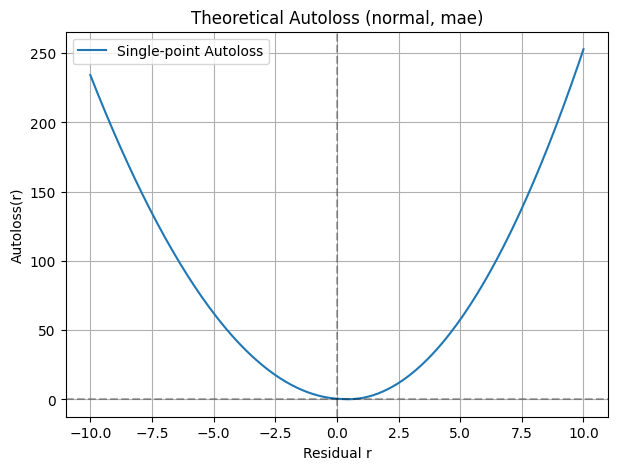

In [11]:
################################################
#    6)  生成理论AutoLoss 并绘制
################################################

# 1) 计算理论AutoLoss (L=\sum_{i=1}^n\sum_{l=1}^L\text{ReLU}[u_l(y_i-x_i^T\beta) +v_l]+\sum_{i=1}^n\sum_{h=1}^H\text{ReHU}_{\gamma_h}[s_h(y_i-x_i^T\beta )+t_h]) )

import numpy as np
import torch
import matplotlib.pyplot as plt

def reHU_piecewise(x, gamma):
    r"""
    实现分段函数 ReHU_gamma(x):
       = 0,                                       if x <= 0
       = 0.5 * x^2,                               if 0 < x < gamma
       = (x^2)/4 + (gamma*x)/2 - (gamma^2)/4,      if x >= gamma

    x, gamma 均可为张量，通过 torch.where 分段拼接。
    """
    cond0 = (x <= 0)
    cond2 = (x >= gamma)
    
    val0 = torch.zeros_like(x)                          # x <= 0
    val1 = 0.5 * x**2                                   # 0 < x < gamma
    val2 = (x**2)/4 + 0.5*gamma*x - (gamma**2)/4        # x >= gamma
    
    out = torch.where(cond0, val0, val1)
    out = torch.where(cond2, val2, out)
    return out

def single_autoloss(r, U, V, S, T, tau):
    r"""
    对单个标量残差 r（或一批 r 向量）计算:
      L_single(r) = sum_{l=1}^L ReLU(u_l*r + v_l)  
                  + sum_{h=1}^H ReHU_tau_h(s_h*r + t_h).

    Args:
        r (torch.Tensor): shape [N], 表示多个残差点
        U, V: shape [L]
        S, T, tau: shape [H]
    Returns:
        torch.Tensor: shape [N], 每个 r 下对应的损失值
    """
    if not isinstance(r, torch.Tensor):
        r = torch.tensor(r, dtype=U.dtype, device=U.device)
    if r.dim() == 0:
        r = r.view(1)  # 保证至少1D
    
    # 部分1: sum_l ReLU(u_l * r + v_l)
    r_vals = r.unsqueeze(0)                 # => shape [1,N]
    uv = U.unsqueeze(1)*r_vals + V.unsqueeze(1)  # => [L,N]
    partL = torch.relu(uv).sum(dim=0)            # => [N]

    # 部分2: sum_h ReHU_{tau_h}(s_h*r + t_h)
    st = S.unsqueeze(1)*r_vals + T.unsqueeze(1)     # [H,N]
    tau_b = tau.unsqueeze(1).expand_as(st)          # [H,N]
    partH = reHU_piecewise(st, tau_b).sum(dim=0)    # [N]
    
    return partL + partH

def plot_theoretical_autoloss(params, r_min=-5, r_max=5, num_points=200):
    r"""
    绘制“单点”理论 Autoloss 随残差 r 的分段曲线.

    Args:
        params (dict): 包含 U, V, S, T, tau 等键的字典
        r_min, r_max (float): 绘制区间
        num_points (int): 采样点数
    """
    U = params["U"]
    V = params["V"]
    S = params["S"]
    T = params["T"]
    # 需要在 params 里也存一下 tau
    # 假设 params["tau"] = tau
    if "tau" not in params:
        raise KeyError("params中必须包含 'tau' 用来表示 ReHU 的门限.")
    tau = params["tau"]

    device = U.device
    r_vals = torch.linspace(r_min, r_max, steps=num_points, device=device)
    
    L_vals = single_autoloss(r_vals, U, V, S, T, tau)
    
    # 转回 numpy 画图
    r_np = r_vals.cpu().numpy()
    L_np = L_vals.cpu().numpy()

    data_distribution = params["data_distribution"]
    scale = params["scale"]
    metric = params["metric"]
    
    plt.figure(figsize=(7,5))
    plt.plot(r_np, L_np, label="Single-point Autoloss")
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.xlabel("Residual r")
    plt.ylabel("Autoloss(r)")
    plt.title(f"Theoretical Autoloss ({data_distribution}, {metric})")
    plt.grid(True)
    plt.legend()
    plt.show()


# 2) 绘制理论AutoLoss

plot_theoretical_autoloss(autoloss_result, r_min=-10, r_max=10, num_points=200)